<a href="https://colab.research.google.com/github/anshulLuhsna/articles/blob/main/1_spectral_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tarfile
import urllib.request
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
CIFAR_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
CIFAR_TAR = "cifar-10-python.tar.gz"
CIFAR_DIR = "cifar-10-batches-py"


def download_and_extract_cifar10():
    if not os.path.exists(CIFAR_DIR):
        print("Downloading CIFAR-10...")
        urllib.request.urlretrieve(CIFAR_URL, CIFAR_TAR)
        print("Extracting...")
        with tarfile.open(CIFAR_TAR, "r:gz") as tar:
            tar.extractall()
        print("Done.")


def load_batch(batch_path):
    with open(batch_path, "rb") as f:
        batch = pickle.load(f, encoding="latin1")
    data = batch["data"]  # shape (10000, 3072)
    labels = np.array(batch["labels"])
    return data, labels


def load_cifar10():
    download_and_extract_cifar10()

    # Load train batches
    xs = []
    ys = []
    for i in range(1, 6):
        batch_path = os.path.join(CIFAR_DIR, f"data_batch_{i}")
        x, y = load_batch(batch_path)
        xs.append(x)
        ys.append(y)
    X_train = np.concatenate(xs, axis=0)  # (50000, 3072)
    y_train = np.concatenate(ys, axis=0)  # (50000,)

    # Load test batch
    X_test, y_test = load_batch(os.path.join(CIFAR_DIR, "test_batch"))

    # Normalize to [0, 1]
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0

    return X_train, y_train, X_test, y_test


In [ ]:
def corrupt_labels(y, corruption_fraction=0.2, num_classes=10, seed=42):
    """
    Randomly corrupt a fraction of labels by replacing them with
    a wrong random class.
    """
    rng = np.random.RandomState(seed)
    y_noisy = y.copy()
    n = len(y)
    num_corrupt = int(corruption_fraction * n)

    indices = rng.choice(n, size=num_corrupt, replace=False)
    random_labels = rng.randint(0, num_classes, size=num_corrupt)

    # Ensure corrupted labels are *different* from original
    same_mask = random_labels == y_noisy[indices]
    while np.any(same_mask):
        random_labels[same_mask] = rng.randint(0, num_classes, size=np.sum(same_mask))
        same_mask = random_labels == y_noisy[indices]

    y_noisy[indices] = random_labels
    return y_noisy, indices


In [ ]:
def one_hot(y, num_classes):
    out = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    out[np.arange(y.shape[0]), y] = 1.0
    return out


def softmax(logits):
    logits = logits - np.max(logits, axis=1, keepdims=True)
    exp = np.exp(logits)
    return exp / np.sum(exp, axis=1, keepdims=True)


class MLP:
    """
    2-layer MLP:
        input -> Linear(3072 -> hidden_dim) -> ReLU -> Linear(hidden_dim -> 10)
    """

    def __init__(self, input_dim=3072, hidden_dim=256, num_classes=10, weight_scale=0.01, seed=0):
        rng = np.random.RandomState(seed)
        self.W1 = weight_scale * rng.randn(input_dim, hidden_dim).astype(np.float32)
        self.b1 = np.zeros((hidden_dim,), dtype=np.float32)
        self.W2 = weight_scale * rng.randn(hidden_dim, num_classes).astype(np.float32)
        self.b2 = np.zeros((num_classes,), dtype=np.float32)

    def forward(self, X):
        """
        Returns:
            logits, cache
        """
        z1 = X.dot(self.W1) + self.b1       # (N, hidden)
        h1 = np.maximum(0, z1)              # ReLU
        logits = h1.dot(self.W2) + self.b2  # (N, C)
        cache = (X, z1, h1, logits)
        return logits, cache

    def loss_and_grads(self, X, y_onehot, reg=0.0):
        """
        Compute softmax cross-entropy loss and gradients.
        """
        N = X.shape[0]
        logits, cache = self.forward(X)
        probs = softmax(logits)

        # Cross-entropy loss
        loss = -np.sum(y_onehot * np.log(probs + 1e-9)) / N
        # L2 regularization
        loss += 0.5 * reg * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))

        # Backprop
        X, z1, h1, logits = cache
        # dL/dlogits
        dlogits = (probs - y_onehot) / N  # (N, C)

        # Grad W2, b2
        dW2 = h1.T.dot(dlogits) + reg * self.W2
        db2 = np.sum(dlogits, axis=0)

        # Backprop into h1
        dh1 = dlogits.dot(self.W2.T)       # (N, hidden)
        dz1 = dh1 * (z1 > 0)               # ReLU backprop

        # Grad W1, b1
        dW1 = X.T.dot(dz1) + reg * self.W1
        db1 = np.sum(dz1, axis=0)

        grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return loss, grads

    def predict(self, X):
        logits, _ = self.forward(X)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)



In [ ]:
def accuracy(model, X, y):
    y_pred = model.predict(X)
    return np.mean(y_pred == y)


def train_mlp_on_cifar():
    # Hyperparameters
    corruption_fraction = 0.2   # 20% noisy labels
    num_classes = 10
    hidden_dim = 256
    learning_rate = 0.1
    reg = 1e-4
    batch_size = 256
    num_epochs = 40  # you can increase to see a longer "slow tail"

    print("Loading CIFAR-10...")
    X_train, y_train_clean, X_test, y_test = load_cifar10()

    # For speed in Colab, optionally subsample
    # (full 50k also works, just slower)
    n_train = 25000
    X_train = X_train[:n_train]
    y_train_clean = y_train_clean[:n_train]

    # Corrupt labels
    y_train_noisy, corrupted_idx = corrupt_labels(
        y_train_clean,
        corruption_fraction=corruption_fraction,
        num_classes=num_classes,
        seed=123,
    )
    print(f"Corrupted {len(corrupted_idx)} labels out of {len(y_train_noisy)}")

    # Train/validation split
    val_fraction = 0.1
    n_val = int(val_fraction * n_train)
    X_val = X_train[:n_val]
    y_val = y_train_noisy[:n_val]
    X_train_sub = X_train[n_val:]
    y_train_sub = y_train_noisy[n_val:]


    # Initialize model
    model = MLP(input_dim=3072, hidden_dim=hidden_dim, num_classes=num_classes)

    # Training state
    num_batches = int(np.ceil(X_train_sub.shape[0] / batch_size))
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    print("Train shape:", X_train_sub.shape, y_train_sub.shape)
    print("Val shape:", X_val.shape, y_val.shape)
    print("Num batches:", num_batches)
    print("Starting training...")
    for epoch in range(1, num_epochs + 1):
        # Shuffle training data each epoch
        perm = np.random.permutation(X_train_sub.shape[0])
        X_train_sub = X_train_sub[perm]
        y_train_sub = y_train_sub[perm]

        epoch_loss = 0.0

        for bi in range(num_batches):
            start = bi * batch_size
            end = min((bi + 1) * batch_size, X_train_sub.shape[0])
            X_batch = X_train_sub[start:end]
            y_batch = y_train_sub[start:end]
            y_batch_onehot = one_hot(y_batch, num_classes)

            loss, grads = model.loss_and_grads(X_batch, y_batch_onehot, reg=reg)
            epoch_loss += loss * (end - start)

            # SGD update
            model.W1 -= learning_rate * grads["W1"]
            model.b1 -= learning_rate * grads["b1"]
            model.W2 -= learning_rate * grads["W2"]
            model.b2 -= learning_rate * grads["b2"]

        # Average loss over epoch
        epoch_loss /= X_train_sub.shape[0]
        train_losses.append(epoch_loss)

        # Compute validation loss + accuracy (optional but useful)
        y_val_onehot = one_hot(y_val, num_classes)
        val_loss, _ = model.loss_and_grads(X_val, y_val_onehot, reg=reg)
        val_losses.append(val_loss)

        train_acc = accuracy(model, X_train_sub, y_train_sub)
        val_acc = accuracy(model, X_val, y_val)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch:02d}/{num_epochs} "
            f"- train loss: {epoch_loss:.4f}, val loss: {val_loss:.4f}, "
            f"train acc (noisy): {train_acc:.3f}, val acc (noisy): {val_acc:.3f}"
        )
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss (with noisy labels)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }

Loading CIFAR-10...
Corrupted 5000 labels out of 25000
Train shape: (22500, 3072) (22500,)
Val shape: (2500, 3072) (2500,)
Num batches: 88
Starting training...
Epoch 01/40 - train loss: 2.2234, val loss: 2.1578, train acc (noisy): 0.225, val acc (noisy): 0.224
Epoch 02/40 - train loss: 2.1256, val loss: 2.0949, train acc (noisy): 0.236, val acc (noisy): 0.248
Epoch 03/40 - train loss: 2.0787, val loss: 2.0676, train acc (noisy): 0.262, val acc (noisy): 0.263
Epoch 04/40 - train loss: 2.0473, val loss: 1.9989, train acc (noisy): 0.313, val acc (noisy): 0.323
Epoch 05/40 - train loss: 2.0173, val loss: 2.1163, train acc (noisy): 0.251, val acc (noisy): 0.249
Epoch 06/40 - train loss: 2.0050, val loss: 1.9598, train acc (noisy): 0.332, val acc (noisy): 0.332
Epoch 07/40 - train loss: 1.9904, val loss: 1.9749, train acc (noisy): 0.325, val acc (noisy): 0.325
Epoch 08/40 - train loss: 1.9698, val loss: 1.9701, train acc (noisy): 0.326, val acc (noisy): 0.332
Epoch 09/40 - train loss: 1.9559

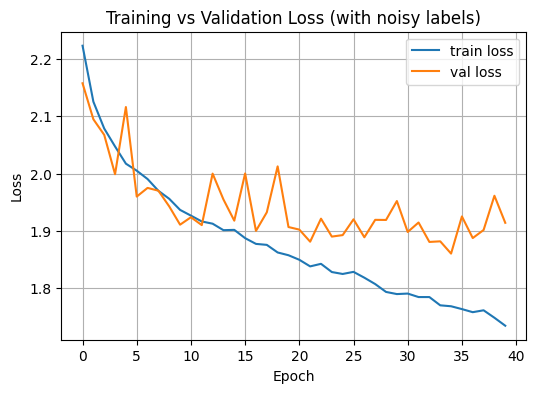

In [ ]:
if __name__ == "__main__":
    model, history = train_mlp_on_cifar()

/tmp/ipython-input-2719275233.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


CIFAR-10 extracted.

=== Training with 0% LABEL NOISE ===
Epoch 1/40 : loss = 2.0565
Epoch 2/40 : loss = 1.8653
Epoch 3/40 : loss = 1.7867
Epoch 4/40 : loss = 1.7254
Epoch 5/40 : loss = 1.6850
Epoch 6/40 : loss = 1.6490
Epoch 7/40 : loss = 1.6208
Epoch 8/40 : loss = 1.6010
Epoch 9/40 : loss = 1.5743
Epoch 10/40 : loss = 1.5556
Epoch 11/40 : loss = 1.5361
Epoch 12/40 : loss = 1.5134
Epoch 13/40 : loss = 1.4983
Epoch 14/40 : loss = 1.4837
Epoch 15/40 : loss = 1.4718
Epoch 16/40 : loss = 1.4530
Epoch 17/40 : loss = 1.4363
Epoch 18/40 : loss = 1.4327
Epoch 19/40 : loss = 1.4128
Epoch 20/40 : loss = 1.4053
Epoch 21/40 : loss = 1.3922
Epoch 22/40 : loss = 1.3831
Epoch 23/40 : loss = 1.3643
Epoch 24/40 : loss = 1.3670
Epoch 25/40 : loss = 1.3571
Epoch 26/40 : loss = 1.3366
Epoch 27/40 : loss = 1.3344
Epoch 28/40 : loss = 1.3265
Epoch 29/40 : loss = 1.3162
Epoch 30/40 : loss = 1.3083
Epoch 31/40 : loss = 1.3027
Epoch 32/40 : loss = 1.2945
Epoch 33/40 : loss = 1.2861
Epoch 34/40 : loss = 1.2793

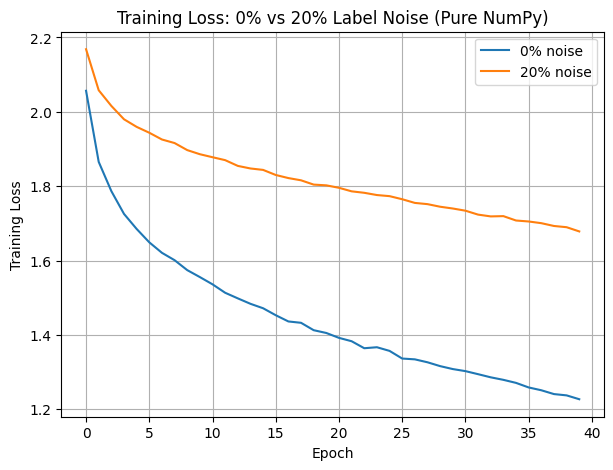

In [ ]:
import numpy as np
import os, tarfile, urllib.request, pickle
import matplotlib.pyplot as plt

# --------------------------------------------------------
# CIFAR-10 LOADING (same as before)
# --------------------------------------------------------

CIFAR_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
CIFAR_TAR = "cifar-10-python.tar.gz"
CIFAR_DIR = "cifar-10-batches-py"

def download_and_extract_cifar10():
    if not os.path.exists(CIFAR_DIR):
        print("Downloading CIFAR-10...")
        urllib.request.urlretrieve(CIFAR_URL, CIFAR_TAR)
        with tarfile.open(CIFAR_TAR, "r:gz") as tar:
            tar.extractall()
        print("CIFAR-10 extracted.")

def load_batch(path):
    with open(path, "rb") as f:
        batch = pickle.load(f, encoding="latin1")
    return batch["data"], np.array(batch["labels"])

def load_cifar10():
    download_and_extract_cifar10()

    xs, ys = [], []
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(CIFAR_DIR, f"data_batch_{i}"))
        xs.append(data)
        ys.append(labels)

    X_train = np.concatenate(xs).astype(np.float32) / 255.0  # (50000, 3072)
    y_train = np.concatenate(ys)

    return X_train, y_train


# --------------------------------------------------------
# LABEL CORRUPTION
# --------------------------------------------------------

def corrupt_labels(y, fraction, seed=0):
    rng = np.random.RandomState(seed)
    y_new = y.copy()
    n = len(y)
    k = int(fraction * n)

    idx = rng.choice(n, size=k, replace=False)
    random_labels = rng.randint(0, 10, size=k)

    # ensure wrong labels
    same = random_labels == y_new[idx]
    while np.any(same):
        random_labels[same] = rng.randint(0, 10, size=np.sum(same))
        same = random_labels == y_new[idx]

    y_new[idx] = random_labels
    return y_new


# --------------------------------------------------------
# SIMPLE NUMPY MLP
# --------------------------------------------------------

def one_hot(y, num_classes=10):
    out = np.zeros((y.size, num_classes), np.float32)
    out[np.arange(y.size), y] = 1
    return out

def softmax(z):
    z = z - z.max(1, keepdims=True)
    exp = np.exp(z)
    return exp / exp.sum(1, keepdims=True)

class MLP:
    def __init__(self, input_dim=3072, hidden=256, classes=10):
        rng = np.random.RandomState(0)
        self.W1 = 0.01 * rng.randn(input_dim, hidden).astype(np.float32)
        self.b1 = np.zeros(hidden, np.float32)
        self.W2 = 0.01 * rng.randn(hidden, classes).astype(np.float32)
        self.b2 = np.zeros(classes, np.float32)

    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        h1 = np.maximum(0, z1)
        logits = h1 @ self.W2 + self.b2
        return logits, (X, z1, h1)

    def loss_and_grads(self, X, y):
        logits, (X_, z1, h1) = self.forward(X)
        probs = softmax(logits)
        y_oh = one_hot(y)
        N = X.shape[0]

        loss = -np.sum(y_oh * np.log(probs + 1e-9)) / N

        dlogits = (probs - y_oh) / N
        dW2 = h1.T @ dlogits
        db2 = dlogits.sum(0)

        dh1 = dlogits @ self.W2.T
        dz1 = dh1 * (z1 > 0)

        dW1 = X.T @ dz1
        db1 = dz1.sum(0)

        grads = (dW1, db1, dW2, db2)
        return loss, grads

    def update(self, grads, lr):
        dW1, db1, dW2, db2 = grads
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2


# --------------------------------------------------------
# TRAINING FUNCTION
# --------------------------------------------------------

def train_cifar(noise=0.0, epochs=40, lr=0.1, batch=256):

    X, y_clean = load_cifar10()
    y = corrupt_labels(y_clean, noise) if noise > 0 else y_clean

    model = MLP()
    N = X.shape[0]
    steps = N // batch

    losses = []

    print(f"\n=== Training with {int(noise*100)}% LABEL NOISE ===")

    for ep in range(epochs):
        perm = np.random.permutation(N)
        X, y = X[perm], y[perm]

        epoch_loss = 0
        for i in range(steps):
            xs = X[i*batch:(i+1)*batch]
            ys = y[i*batch:(i+1)*batch]

            loss, grads = model.loss_and_grads(xs, ys)
            model.update(grads, lr)
            epoch_loss += loss

        losses.append(epoch_loss / steps)
        print(f"Epoch {ep+1}/{epochs} : loss = {losses[-1]:.4f}")

    return losses


# --------------------------------------------------------
# RUN BOTH EXPERIMENTS
# --------------------------------------------------------

loss_clean = train_cifar(noise=0.0, epochs=40)
loss_noisy = train_cifar(noise=0.2, epochs=40)

# --------------------------------------------------------
# PLOT 0% vs 20% NOISE
# --------------------------------------------------------

plt.figure(figsize=(7,5))
plt.plot(loss_clean, label="0% noise")
plt.plot(loss_noisy, label="20% noise")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss: 0% vs 20% Label Noise (Pure NumPy)")
plt.legend()
plt.grid(True)
plt.show()


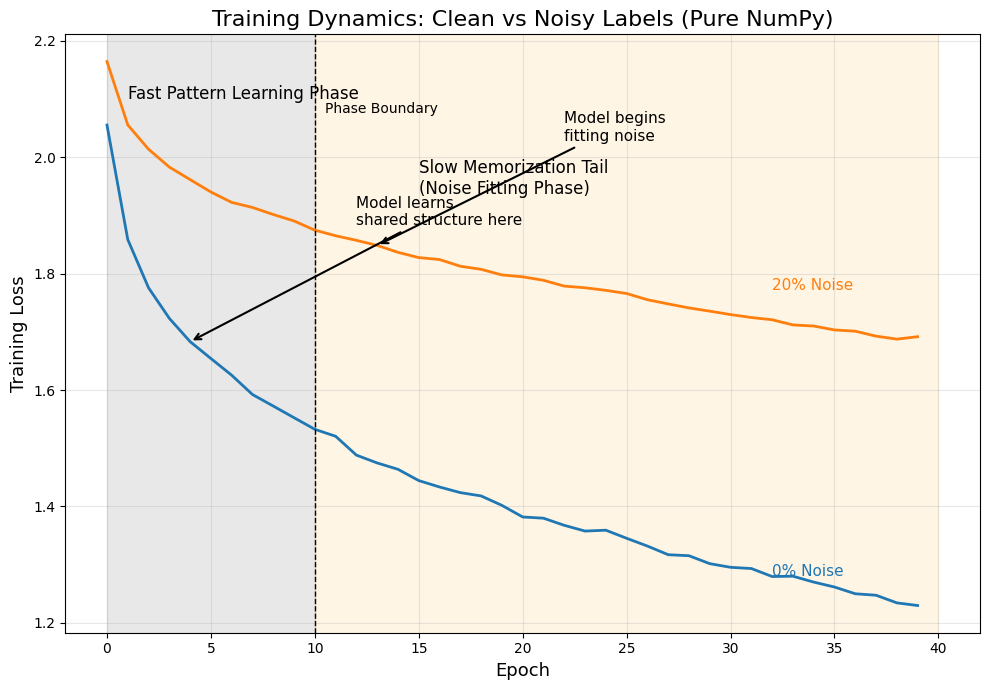

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(len(loss_clean))
phase_boundary = 10

plt.figure(figsize=(10,7))

# Plot curves
plt.plot(epochs, loss_clean, label="0% Noise", linewidth=2, color="#1f77b4")
plt.plot(epochs, loss_noisy, label="20% Noise", linewidth=2, color="#ff7f0e")

# --------------------------
# Shaded regions (no overlap)
# --------------------------
plt.axvspan(0, phase_boundary, color='gray', alpha=0.18)
plt.axvspan(phase_boundary, len(epochs), color='orange', alpha=0.10)

# Vertical boundary line
plt.axvline(phase_boundary, color='black', linestyle='--', linewidth=1)
plt.text(phase_boundary + 0.5,
         max(loss_clean) + 0.02,
         "Phase Boundary",
         fontsize=10)

# --------------------------
# Region labels (fixed positions)
# --------------------------
plt.text(1.0, max(loss_noisy)*0.97,
         "Fast Pattern Learning Phase",
         fontsize=12, color="black")

plt.text(phase_boundary + 5,
         min(loss_noisy) + 0.25,
         "Slow Memorization Tail\n(Noise Fitting Phase)",
         fontsize=12, color="black")

# --------------------------
# Arrow annotations (repositioned)
# --------------------------
# Arrow 1 (clean curve)
plt.annotate("Model learns\nshared structure here",
             xy=(4, loss_clean[4]),
             xytext=(12, loss_clean[4] + 0.20),
             fontsize=11,
             arrowprops=dict(arrowstyle="->", lw=1.5, color="black"))

# Arrow 2 (noisy curve)
plt.annotate("Model begins\nfitting noise",
             xy=(phase_boundary + 3, loss_noisy[phase_boundary + 3]),
             xytext=(phase_boundary + 12, loss_noisy[phase_boundary + 3] + 0.18),
             fontsize=11,
             arrowprops=dict(arrowstyle="->", lw=1.5, color="black"))

# --------------------------
# Curve labels (moved away from arrows)
# --------------------------
plt.text(len(epochs) - 8,
         loss_clean[-1] + 0.05,
         "0% Noise", color="#1f77b4", fontsize=11)

plt.text(len(epochs) - 8,
         loss_noisy[-1] + 0.08,
         "20% Noise", color="#ff7f0e", fontsize=11)

# --------------------------
# Formatting
# --------------------------
plt.title("Training Dynamics: Clean vs Noisy Labels (Pure NumPy)", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Training Loss", fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()
